In [1]:
import Library_functions as lf
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import numpy as np
warnings.filterwarnings("ignore")

## Data and materials for "Exploring the spatial segmentation of housing markets from online listings"

This folder contains the materials from the publication: "Exploring the spatial segmentation of housing markets from online listings".

It includes the weighted networks of spatial units, where the link between two spatial units account not only for the presence of common real estate agencies operating in both units but also its influence, accounting for the relative share of those agencies in that spatial units.

We construct the networks using 3 different spatial units: 1000 m square grid cells, municipalities and census tracts. 

### Networks using $1000 \, \times \, 1000 \; m^2$ square cells as spatial units

In [20]:
sitio = "bal"

cell_size = 1000

In [21]:
# Create grid in our province with the given cell size
grid = lf.create_grid_place(sitio,cell_size)
grid["index_cell"] = grid["index_cell"].astype(str)

Number of cells 2000 x 2000:  1518
Number of cells 1000 x 1000:  6072


In [22]:
# Now we extract the data from the network
G = nx.read_edgelist("./DATA/1000m_CELLS/G1000_cell_"+sitio+".dat", delimiter="    ", data=(('weight', float),))

In [23]:
# Now we want to plot just the cells in the grid that are in the network
nodes = list(G.nodes)

# Now we create a new grid with only the nodes in the network
grid_in_network = grid[grid['index_cell'].isin(nodes)]

grid_in_network["centroid"] = grid_in_network["geometry"].centroid
grid_in_network["x"] = grid_in_network["centroid"].x
grid_in_network["y"] = grid_in_network["centroid"].y

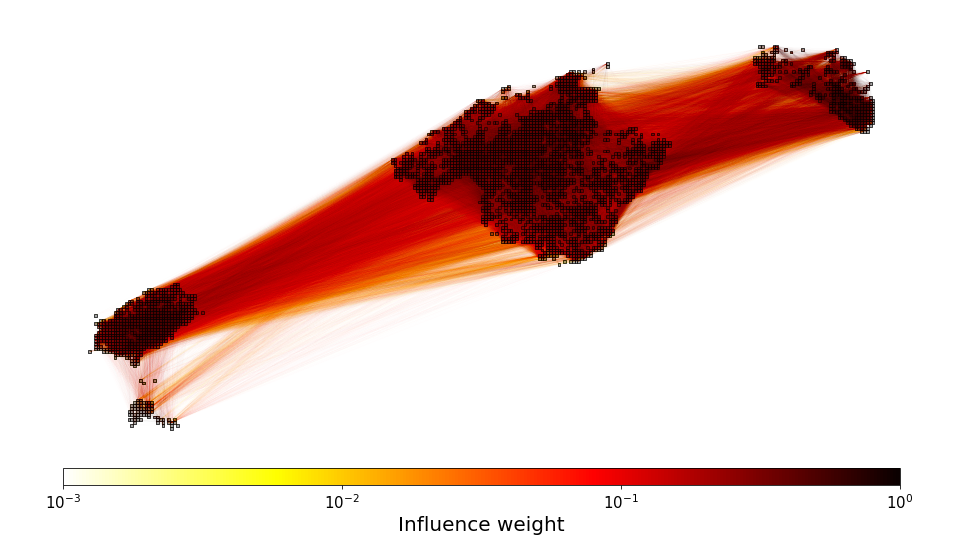

In [26]:
# Now we plot the grid
fig, ax = plt.subplots(figsize=(20,10))
grid_in_network.plot(ax=ax, color="grey", edgecolor="black", alpha=0.7)

# First we create a dictionary with the position of each node
pos = {node: [float(grid_in_network[grid_in_network['index_cell'] == node]["x"]), float(grid_in_network[grid_in_network['index_cell'] == node]["y"])] for node in nodes}

alpha_arr = np.log10([G[u][v]['weight'] for u,v in G.edges])
alpha_arr = alpha_arr - np.min(alpha_arr)
alpha_arr = alpha_arr/np.max(alpha_arr)

# Now we plot the network on top of the grid with the color of the edges based on the weight
nx.draw(G, ax=ax, pos=pos, node_size=0.1, edge_color=[np.log10(G[u][v]['weight']+10**(-12)) for u,v in G.edges], edge_cmap=plt.cm.hot_r, edge_vmin=-3, edge_vmax=0, alpha=0.005*alpha_arr)

# Now we plot the colorbar at the top of the plot in horizontal
sm = plt.cm.ScalarMappable(cmap=plt.cm.hot_r, norm=plt.Normalize(-3,0))
cbar = fig.colorbar(sm, orientation='horizontal', pad=0, aspect=50, shrink=0.75)
cbar.set_label('Influence weight', fontsize=20)
cbar.ax.tick_params(labelsize=15)

# The ticks of the colorbar should be in log scale
cbar.set_ticks([-3, -2, -1, 0])
cbar.set_ticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])

### Networks using Census-tracts as spatial units

In [27]:
name = sitio
cpro = 0

if sitio == "bal":
    name = "Baleares"
    cpro = "07"
elif sitio == "mad":
    name = "Madrid"
    cpro = "28"
else:
    name = "Barcelona"
    cpro = "08"

In [28]:
# Now we read the information about CENSUS in balearic islands
path_palma = './DATA/shapefile/Seccionado_2021/SECC_CE_20210101.shp'
shp = gpd.read_file(path_palma, geometry='geometry')
shp = shp.to_crs('epsg:3035')
shp = shp[shp.CPRO == cpro]
shp = shp[['CUSEC','NMUN','geometry']].reset_index(drop=True)
shp["CUSEC"] = [str(int(x)) for x in shp["CUSEC"]]

In [29]:
# Now we extract the data from the network
G_census = nx.read_edgelist("./DATA/CENSUS/G_census_"+sitio+".dat", delimiter="    ", data=(('weight', float),))

In [30]:
# Now we want to plot just the census in the graph that are in the network
nodes_census = list(G_census.nodes)

# Now we create a new grid with only the nodes in the network
census_in_network = shp[shp['CUSEC'].isin(nodes_census)]

census_in_network["centroid"] = census_in_network["geometry"].centroid
census_in_network["x"] = census_in_network["centroid"].x
census_in_network["y"] = census_in_network["centroid"].y

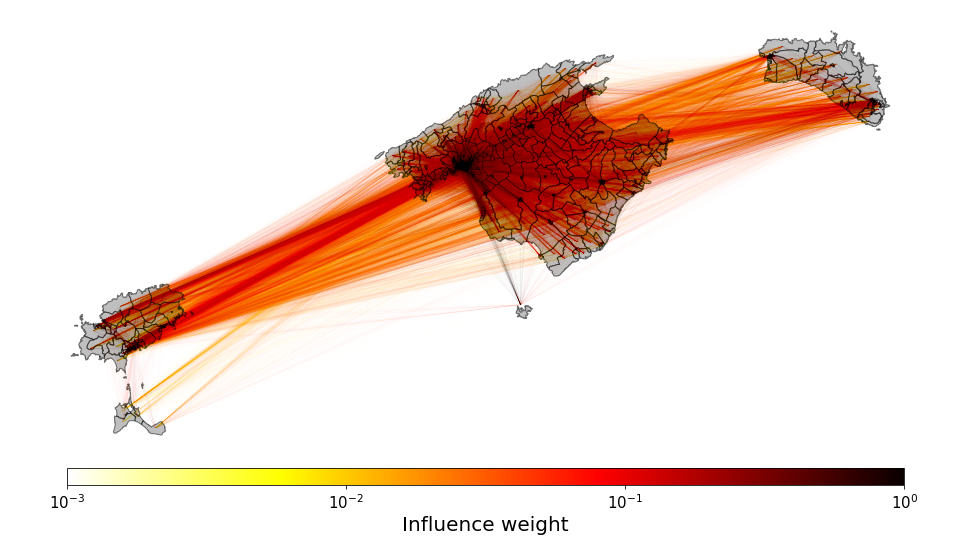

In [31]:
# Now we plot the CENSUS
fig, ax = plt.subplots(figsize=(20,10))
shp.plot(ax=ax, color="grey", edgecolor='black', alpha=0.5)

# First we create a dictionary with the position of each node
pos = {node: [float(census_in_network[census_in_network['CUSEC'] == node]["x"]), float(census_in_network[census_in_network['CUSEC'] == node]["y"])] for node in nodes_census}

alpha_arr = np.log10([G_census[u][v]['weight'] for u,v in G_census.edges])
alpha_arr = alpha_arr - np.min(alpha_arr)
alpha_arr = alpha_arr/np.max(alpha_arr)

# Now we plot the network on top of the grid with the color of the edges based on the weight
nx.draw(G_census, ax=ax, pos=pos, node_size=50, node_color="black", edge_color=[np.log10(G_census[u][v]['weight']+10**(-12)) for u,v in G_census.edges], edge_cmap=plt.cm.hot_r, edge_vmin=-3, edge_vmax=0, alpha=0.005*alpha_arr)

# Now we plot the colorbar at the top of the plot in horizontal
sm = plt.cm.ScalarMappable(cmap=plt.cm.hot_r, norm=plt.Normalize(-3,0))
cbar = fig.colorbar(sm, orientation='horizontal', pad=0, aspect=50, shrink=0.75)
cbar.set_label('Influence weight', fontsize=20)
cbar.ax.tick_params(labelsize=15)

# The ticks of the colorbar should be in log scale
cbar.set_ticks([-3, -2, -1, 0])
cbar.set_ticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])

### Networks using Municipalities as spatial units

In [32]:
# Now we read the information about CENSUS in balearic islands
path_palma = './DATA/shapefile/Seccionado_2021/SECC_CE_20210101.shp'
shp = gpd.read_file(path_palma, geometry='geometry')
shp = shp.to_crs('epsg:3035')
shp = shp[shp.CPRO == cpro]
shp = shp.dissolve(by='CUMUN').reset_index()
shp = shp[['CUMUN','NMUN','geometry']].reset_index(drop=True)
shp["CUMUN"] = [str(int(x)) for x in shp["CUMUN"]]

In [33]:
# Now we extract the data from the network
G_mun = nx.read_edgelist("./DATA/MUNICIPALITIES/G_mun_"+sitio+".dat", delimiter="    ", data=(('weight', float),))

In [34]:
# Now we want to plot just the municipalities in the graph that are in the network
nodes_mun = list(G_mun.nodes)

# Now we create a new grid with only the nodes in the network
mun_in_network = shp[shp['CUMUN'].isin(nodes_mun)]

mun_in_network["centroid"] = mun_in_network["geometry"].centroid
mun_in_network["x"] = mun_in_network["centroid"].x
mun_in_network["y"] = mun_in_network["centroid"].y

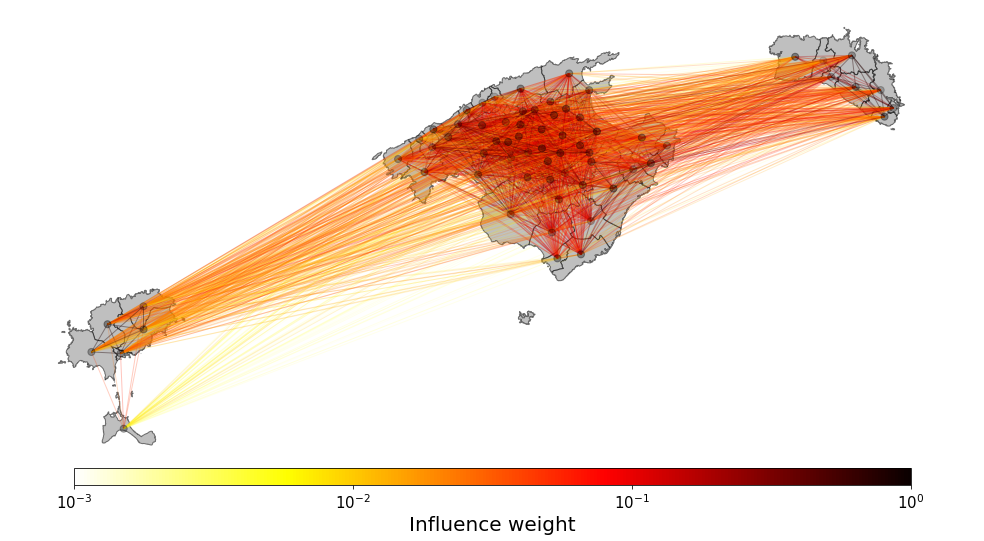

In [35]:
# Now we plot the municipalities
fig, ax = plt.subplots(figsize=(20,10))
shp.plot(ax=ax, color="grey", edgecolor='black', alpha=0.5)

# First we create a dictionary with the position of each node
pos = {node: [float(mun_in_network[mun_in_network['CUMUN'] == node]["x"]), float(mun_in_network[mun_in_network['CUMUN'] == node]["y"])] for node in nodes_mun}

alpha_arr = np.log10([G_mun[u][v]['weight'] for u,v in G_mun.edges])
alpha_arr = alpha_arr - np.min(alpha_arr)
alpha_arr = alpha_arr/np.max(alpha_arr)

# Now we plot the network on top of the grid with the color of the edges based on the weight
nx.draw(G_mun, ax=ax, pos=pos, node_size=50, node_color="black", edge_color=[np.log10(G_mun[u][v]['weight']+10**(-12)) for u,v in G_mun.edges], edge_cmap=plt.cm.hot_r, edge_vmin=-3, edge_vmax=0, alpha=0.4*alpha_arr)

# Now we plot the colorbar at the top of the plot in horizontal
sm = plt.cm.ScalarMappable(cmap=plt.cm.hot_r, norm=plt.Normalize(-3,0))
cbar = fig.colorbar(sm, orientation='horizontal', pad=0, aspect=50, shrink=0.75)
cbar.set_label('Influence weight', fontsize=20)
cbar.ax.tick_params(labelsize=15)

# The ticks of the colorbar should be in log scale
cbar.set_ticks([-3, -2, -1, 0])
cbar.set_ticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])